# Colab Notebook: Trening DDPM + DDIM z opcjonalnym VAE

Ten notebook pokazuje krok po kroku, jak w Google Colab:

1. Skonfigurować Kaggle API i pobrać dane
2. Zdefiniować VAE i trenować go z Early Stopping
3. Zdefiniować prosty UNet i klasę DiffusionModel (DDPM + metodę DDIM)
4. Trenować model dyfuzji (DDPM) z AMP i Early Stopping
5. Generować próbki DDIM

Możesz podmienić dataset, hiperparametry i ścieżki według potrzeb.

In [ ]:
# Cell 1: Montowanie Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Ustawienie OUT_DIR na folder PGM_Project
OUT_DIR = '/content/drive/MyDrive/PGM_Project'
import os
os.makedirs(OUT_DIR, exist_ok=True)
print(f"Wyniki będą zapisywane w: {OUT_DIR}")

Mounted at /content/drive
Wyniki będą zapisywane w: /content/drive/MyDrive/PGM_Project


In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
# Cell 1.3: Instalacja torchmetrics
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.2 MB/s eta 0:00:00


In [ ]:
# Cell 1.4: Instalacja zależności do FID
!pip install -q torchmetrics[image] torch-fidelity

In [ ]:
# Cell 2: Importy i hiperparametry
import os
import torch
import torch.nn.functional as F
from torch_fidelity import calculate_metrics
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
from diffusers import DDPMScheduler, UNet2DModel, AutoencoderKL, DiffusionPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from accelerate import Accelerator
from torchmetrics.image.fid import FrechetInceptionDistance as FID

In [ ]:
# Hiperparametry
IMG_SIZE      = 96
BATCH_SIZE    = 16
EPOCHS        = 30
LR            = 1e-4
TIMESTEPS     = 1000
SAMPLE_STEPS  = 50
NUM_SAMPLES   = 8
ETA           = 0.0
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

USE_VAE       = False  # Zmieniaj na True, jeśli chcesz trenować z VAE
VAEPATH       = None
RUN_NAME      = "no_vae" if not USE_VAE else "vae"
OUT_DIR       = f"/content/drive/MyDrive/PGM_Project/{RUN_NAME}"

os.makedirs(OUT_DIR, exist_ok=True)

In [ ]:
# Cell 3: Przygotowanie DataLoaderów – podział na train/val/test (70/20/10)
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms

# Transformacje obrazów
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
])

# Pobranie zbioru STL-10 (train split)
full_train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)

# Obliczenie rozmiarów podzbiorów
total = len(full_train_dataset)
train_n = int(0.7 * total)
val_n   = int(0.2 * total)
test_n  = total - train_n - val_n

# Podział
train_ds, val_ds, test_ds = random_split(full_train_dataset, [train_n, val_n, test_n])

# DataLoadery
train_loader = DataLoader(train_ds,  batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,    batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_ds)} obrazów, Val: {len(val_ds)} obrazów, Test: {len(test_ds)} obrazów")

100%|██████████| 2.64G/2.64G [01:14<00:00, 35.3MB/s]


Train: 3500 obrazów, Val: 1000 obrazów, Test: 500 obrazów


In [ ]:
# Cell 4: Model VAE, UNet i scheduler
# VAE
vae = None
if USE_VAE:
    if VAEPATH:
        vae = AutoencoderKL.from_pretrained(VAEPATH).to(DEVICE)
    else:
        vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(DEVICE)

# UNet
unet = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=[128, 256, 256, 512],
    down_block_types=["DownBlock2D"] * 4,
    up_block_types=["UpBlock2D"] * 4,
).to(DEVICE)

# Scheduler (cosine)
scheduler = DDPMScheduler(
    beta_start=1e-4,
    beta_end=0.02,
    beta_schedule="squaredcos_cap_v2",
    num_train_timesteps=TIMESTEPS
)

In [ ]:
# Cell 5: Optymalizator, lr-scheduler, Accelerator, FID
optimizer = torch.optim.AdamW(
    list(unet.parameters()) + (list(vae.parameters()) if USE_VAE else []),
    lr=LR
)
total_steps = len(train_loader) * EPOCHS
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=500, num_training_steps=total_steps
)
accelerator = Accelerator(mixed_precision="fp16")
unet, vae, optimizer, train_loader, lr_scheduler = accelerator.prepare(
    unet, vae, optimizer, train_loader, lr_scheduler
)
fid_metric = FID(feature=2048, normalize=True).to(DEVICE)

## Trening modelu bez VAE i generacja próbek.

In [ ]:
import os
import time
import pandas as pd
from tqdm.notebook import tqdm
from torchmetrics.image.fid import FrechetInceptionDistance as FID
from diffusers import DDIMPipeline

# === KONFIGURACJA RUNA ===
USE_VAE = False  # lub False
RUN_NAME = "vae" if USE_VAE else "no_vae"
OUT_DIR = os.path.join("/content/drive/MyDrive/PGM_Project", RUN_NAME)
os.makedirs(OUT_DIR, exist_ok=True)

# === START ===
start_time = time.perf_counter()
best_fid = float('inf')

pipe_val = DDIMPipeline(unet=unet, scheduler=scheduler)
if USE_VAE and vae is not None:
    pipe_val.vae = vae
pipe_val.to(DEVICE)

unet_path = os.path.join(OUT_DIR, 'unet_best.pt')
vae_path = os.path.join(OUT_DIR, 'vae_best.pt')

if os.path.exists(unet_path):
    unet.load_state_dict(torch.load(unet_path, map_location=DEVICE))
    print(f"Wczytano wagi UNet z {unet_path}")

if USE_VAE and vae is not None and os.path.exists(vae_path):
    vae.load_state_dict(torch.load(vae_path, map_location=DEVICE))
    print(f"Wczytano wagi VAE z {vae_path}")

fid_metric = FID(feature=2048, normalize=True).to(DEVICE)

# === LOGI ===
fid_history = []
loss_history = []
train_times = []
gen_times = []

for epoch in range(EPOCHS):
    epoch_start = time.perf_counter()
    unet.train()
    epoch_loss = 0.0
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)

    for batch in train_loop:
        pixel_values = batch[0].to(DEVICE)
        if USE_VAE:
            vae.eval()
            with torch.no_grad():
                latents = vae.encode(pixel_values).latent_dist.sample() * vae.config.scaling_factor
        else:
            latents = pixel_values

        timesteps = torch.randint(0, TIMESTEPS, (latents.size(0),), device=DEVICE)
        noise = torch.randn_like(latents)
        noisy_latents = scheduler.add_noise(latents, noise=noise, timesteps=timesteps)

        noise_pred = unet(noisy_latents, timesteps).sample
        loss = F.mse_loss(noise_pred, noise)

        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_train_loss)
    train_time = time.perf_counter() - epoch_start
    train_times.append(train_time)

    print(f"Epoch {epoch+1}/{EPOCHS} — Train Loss: {avg_train_loss:.4f}, Epoch Time: {train_time:.2f} s")

    # === ZAPIS MODELU PRZED FID ===
torch.save(unet.state_dict(), unet_path)
print(f"Zapisano UNet przed ewaluacją FID: {unet_path}")
if USE_VAE and vae is not None:
    torch.save(vae.state_dict(), vae_path)
    print(f"Zapisano VAE przed ewaluacją FID: {vae_path}")

# === FID NA KOŃCU ===
print("Trening zakończony, liczenie FID na końcu...")

unet.eval()
fid_metric.reset()
gen_start = time.perf_counter()

# # Real images
for imgs, _ in val_loader:
    imgs = imgs.to(DEVICE)
    if USE_VAE:
        vae.eval()
        imgs = vae.decode(imgs / vae.config.scaling_factor).sample
    fid_metric.update(imgs, real=True)

# # Fake images
num_fake = 500
fake_images = []
with torch.no_grad():
    while len(fake_images) < num_fake:
        batch_size = min(NUM_SAMPLES, num_fake - len(fake_images))
        batch_imgs = pipe_val(
            batch_size=batch_size,
            num_inference_steps=SAMPLE_STEPS,
            eta=ETA
        ).images
        fake_images.extend(batch_imgs)

fake_tensors = torch.stack([transforms.ToTensor()(im).to(DEVICE) for im in fake_images])
fid_metric.update(fake_tensors, real=False)

fid_score = fid_metric.compute()
fid_score = fid_score.item()  # konwertuj tensor na float
fid_history.append(fid_score)









gen_time = time.perf_counter() - gen_start
gen_times.append(gen_time)

print(f"Final FID: {fid_score:.2f}, Generowanie próbek trwało: {gen_time/60:.2f} min")

# === ZAPIS ===
df = pd.DataFrame({
    "epoch": list(range(1, EPOCHS + 1)),
    "loss": loss_history,
    "train_time": train_times
})
df["final_fid"] = fid_score
df["gen_time"] = gen_time

df.to_csv(os.path.join(OUT_DIR, "training_log.csv"), index=False)

total_time = time.perf_counter() - start_time
print(f"Total training time: {total_time/60:.2f} minutes")
print(f"Wyniki zapisane do folderu: {OUT_DIR}")

Wczytano wagi UNet z /content/drive/MyDrive/PGM_Project/no_vae/unet_best.pt


Epoch 1/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 1/30 — Train Loss: 0.0529, Epoch Time: 114.05 s


Epoch 2/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 2/30 — Train Loss: 0.0457, Epoch Time: 118.25 s


Epoch 3/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 3/30 — Train Loss: 0.0443, Epoch Time: 119.83 s


Epoch 4/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 4/30 — Train Loss: 0.0390, Epoch Time: 119.42 s


Epoch 5/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 5/30 — Train Loss: 0.0392, Epoch Time: 119.23 s


Epoch 6/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 6/30 — Train Loss: 0.0387, Epoch Time: 119.26 s


Epoch 7/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 7/30 — Train Loss: 0.0343, Epoch Time: 119.12 s


Epoch 8/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 8/30 — Train Loss: 0.0349, Epoch Time: 119.08 s


Epoch 9/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 9/30 — Train Loss: 0.0354, Epoch Time: 118.89 s


Epoch 10/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 10/30 — Train Loss: 0.0329, Epoch Time: 118.93 s


Epoch 11/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 11/30 — Train Loss: 0.0350, Epoch Time: 119.02 s


Epoch 12/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 12/30 — Train Loss: 0.0339, Epoch Time: 119.03 s


Epoch 13/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 13/30 — Train Loss: 0.0323, Epoch Time: 119.12 s


Epoch 14/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 14/30 — Train Loss: 0.0333, Epoch Time: 119.04 s


Epoch 15/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 15/30 — Train Loss: 0.0322, Epoch Time: 119.18 s


Epoch 16/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 16/30 — Train Loss: 0.0292, Epoch Time: 119.06 s


Epoch 17/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 17/30 — Train Loss: 0.0318, Epoch Time: 119.14 s


Epoch 18/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 18/30 — Train Loss: 0.0288, Epoch Time: 119.13 s


Epoch 19/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 19/30 — Train Loss: 0.0309, Epoch Time: 119.22 s


Epoch 20/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 20/30 — Train Loss: 0.0310, Epoch Time: 119.25 s


Epoch 21/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 21/30 — Train Loss: 0.0308, Epoch Time: 119.34 s


Epoch 22/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 22/30 — Train Loss: 0.0292, Epoch Time: 119.23 s


Epoch 23/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 23/30 — Train Loss: 0.0295, Epoch Time: 119.20 s


Epoch 24/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 24/30 — Train Loss: 0.0298, Epoch Time: 118.99 s


Epoch 25/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 25/30 — Train Loss: 0.0295, Epoch Time: 119.19 s


Epoch 26/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 26/30 — Train Loss: 0.0297, Epoch Time: 119.24 s


Epoch 27/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 27/30 — Train Loss: 0.0294, Epoch Time: 119.19 s


Epoch 28/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 28/30 — Train Loss: 0.0299, Epoch Time: 119.46 s


Epoch 29/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 29/30 — Train Loss: 0.0286, Epoch Time: 119.23 s


Epoch 30/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 30/30 — Train Loss: 0.0292, Epoch Time: 119.35 s
Zapisano UNet przed ewaluacją FID: /content/drive/MyDrive/PGM_Project/no_vae/unet_best.pt
Trening zakończony, liczenie FID na końcu...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Final FID: 218.39, Generowanie próbek trwało: 5.47 min
Total training time: 65.00 minutes
Wyniki zapisane do folderu: /content/drive/MyDrive/PGM_Project/no_vae


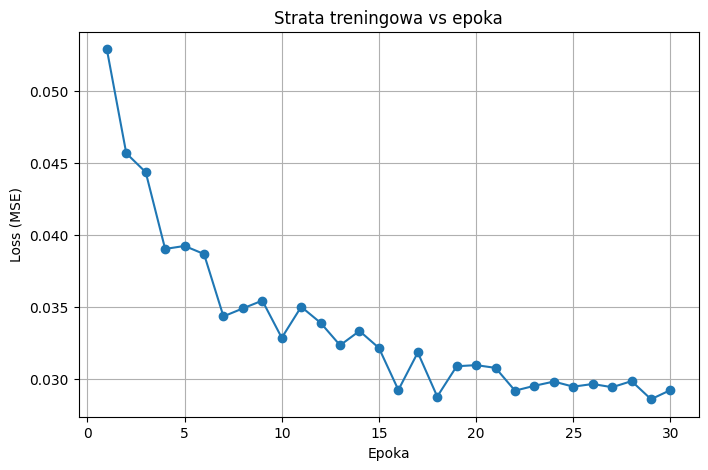

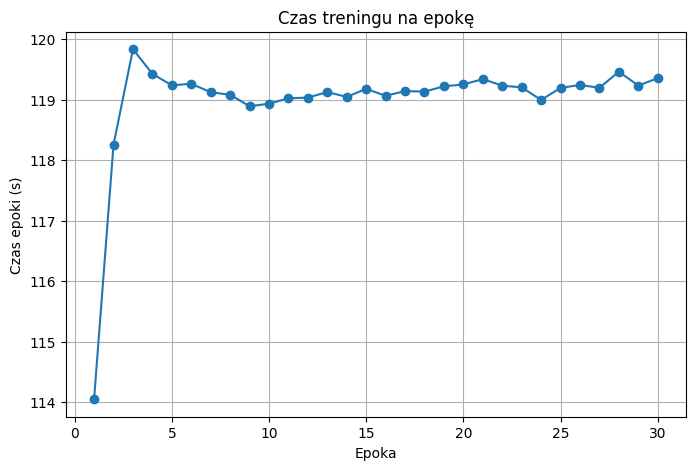

Finalny FID (na 10k próbkach): 218.39
Czas generowania 10k próbek: 5.47 min


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ścieżka do wyników
OUT_DIR = os.path.join("/content/drive/MyDrive/PGM_Project", "vae" if USE_VAE else "no_vae")
log_path = os.path.join(OUT_DIR, "training_log.csv")

# Wczytanie danych
df = pd.read_csv(log_path)

# === WYKRES LOSS vs EPOKA ===
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["loss"], marker="o")
plt.xlabel("Epoka")
plt.ylabel("Loss (MSE)")
plt.title("Strata treningowa vs epoka")
plt.grid(True)
plt.show()

# === WYKRES CZASU TRENINGU vs EPOKA ===
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["train_time"], marker="o")
plt.xlabel("Epoka")
plt.ylabel("Czas epoki (s)")
plt.title("Czas treningu na epokę")
plt.grid(True)
plt.show()

# === FID (po treningu) ===
fid = df["final_fid"].iloc[0] if "final_fid" in df.columns else None
if fid is not None:
    fid = float(fid)
    print(f"Finalny FID (na 10k próbkach): {fid:.2f}")
else:
    print("Brak danych o FID w logu.")

# === CZAS GENERACJI PRÓBEK ===
gen_time = df["gen_time"].iloc[0] if "gen_time" in df.columns else None
if gen_time is not None:
    gen_time = float(gen_time)
    print(f"Czas generowania 10k próbek: {gen_time/60:.2f} min")

In [ ]:
import os
import torch
import time
from PIL import Image
from tqdm.notebook import tqdm
import json

# === KONFIGURACJA ===
USE_VAE = False
RUN_NAME = "vae" if USE_VAE else "no_vae"
OUT_DIR = os.path.join("/content/drive/MyDrive/PGM_Project", RUN_NAME, "samples")
os.makedirs(OUT_DIR, exist_ok=True)

NUM_SAMPLES = 50       # Całkowita liczba próbek do wygenerowania
BATCH_SIZE = 32        # Liczba próbek na batch
SAMPLE_STEPS = 50      # Liczba kroków DDIM
ETA = 0.0              # DDIM eta (0=deterministyczny)
SEED = 42              # Stały seed dla powtarzalności

# === USTAWIENIE SEEDU ===
torch.manual_seed(SEED)

# === PRZYGOTOWANIE PIPELINE ===
pipe = DDIMPipeline(unet=unet, scheduler=scheduler)
if USE_VAE and vae is not None:
    pipe.vae = vae
pipe = pipe.to(DEVICE)

# === GENERACJA ===
print(f"Generowanie {NUM_SAMPLES} próbek (model: {RUN_NAME}, seed: {SEED})...")

fake_images = []
gen_start = time.perf_counter()

pipe.unet.eval()
if USE_VAE and vae is not None:
    pipe.vae.eval()

with torch.no_grad():
    for _ in tqdm(range(0, NUM_SAMPLES, BATCH_SIZE)):
        current_batch = min(BATCH_SIZE, NUM_SAMPLES - len(fake_images))

        batch_imgs = pipe(
            batch_size=current_batch,
            num_inference_steps=SAMPLE_STEPS,
            eta=ETA
        ).images

        fake_images.extend(batch_imgs)

gen_time = time.perf_counter() - gen_start

# === ZAPIS PRÓBEK ===
for i, img in enumerate(fake_images):
    img_path = os.path.join(OUT_DIR, f"sample_{i+1:04d}.png")
    img.save(img_path)

print(f"Gotowe! Zapisano {len(fake_images)} próbek do: {OUT_DIR}")
print(f"Czas generacji: {gen_time / 60:.2f} minut")

Generowanie 50 próbek (model: no_vae, seed: 42)...


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Gotowe! Zapisano 50 próbek do: /content/drive/MyDrive/PGM_Project/no_vae/samples
Czas generacji: 0.51 minut


## Trening modelu z VAE i generacja próbek.

In [ ]:
# === KONFIGURACJA RUNA ===
USE_VAE = True  # lub False
RUN_NAME = "vae" if USE_VAE else "no_vae"
OUT_DIR = os.path.join("/content/drive/MyDrive/PGM_Project", RUN_NAME)
os.makedirs(OUT_DIR, exist_ok=True)

In [ ]:
# Cell 4: Model VAE, UNet i scheduler
# VAE
vae = None
if USE_VAE:
    if VAEPATH:
        vae = AutoencoderKL.from_pretrained(VAEPATH).to(DEVICE)
    else:
        vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(DEVICE)

# UNet
unet = UNet2DModel(
    sample_size=12,
    in_channels=4,
    out_channels=4,
    layers_per_block=2,
    block_out_channels=[128, 256],
    down_block_types=["DownBlock2D"] * 2,
    up_block_types=["UpBlock2D"] * 2,
).to(DEVICE)

# Scheduler (cosine)
scheduler = DDPMScheduler(
    beta_start=1e-4,
    beta_end=0.02,
    beta_schedule="squaredcos_cap_v2",
    num_train_timesteps=TIMESTEPS
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [ ]:
# Cell 5: Optymalizator, lr-scheduler, Accelerator, FID
optimizer = torch.optim.AdamW(
    list(unet.parameters()) + (list(vae.parameters()) if USE_VAE else []),
    lr=LR
)
total_steps = len(train_loader) * EPOCHS
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=500, num_training_steps=total_steps
)
accelerator = Accelerator(mixed_precision="fp16")
unet, vae, optimizer, train_loader, lr_scheduler = accelerator.prepare(
    unet, vae, optimizer, train_loader, lr_scheduler
)
fid_metric = FID(feature=2048, normalize=True).to(DEVICE)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:01<00:00, 89.3MB/s]


In [ ]:
import os
import time
import pandas as pd
from tqdm.notebook import tqdm
from torchmetrics.image.fid import FrechetInceptionDistance as FID
from diffusers import DDIMPipeline

# === START ===
start_time = time.perf_counter()
best_fid = float('inf')

pipe_val = DDIMPipeline(unet=unet, scheduler=scheduler)
if USE_VAE and vae is not None:
    pipe_val.vae = vae
pipe_val.to(DEVICE)

unet_path = os.path.join(OUT_DIR, 'unet_best.pt')
vae_path = os.path.join(OUT_DIR, 'vae_best.pt')

if os.path.exists(unet_path):
    unet.load_state_dict(torch.load(unet_path, map_location=DEVICE))
    print(f"Wczytano wagi UNet z {unet_path}")

if USE_VAE and vae is not None and os.path.exists(vae_path):
    vae.load_state_dict(torch.load(vae_path, map_location=DEVICE))
    print(f"Wczytano wagi VAE z {vae_path}")

fid_metric = FID(feature=2048, normalize=True).to(DEVICE)

# === LOGI ===
fid_history = []
loss_history = []
train_times = []
gen_times = []

for epoch in range(EPOCHS):
    epoch_start = time.perf_counter()
    unet.train()
    epoch_loss = 0.0
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)

    for batch in train_loop:
        pixel_values = batch[0].to(DEVICE)
        if USE_VAE:
            vae.eval()
            with torch.no_grad():
                latents = vae.encode(pixel_values).latent_dist.sample() * vae.config.scaling_factor
        else:
            latents = pixel_values

        timesteps = torch.randint(0, TIMESTEPS, (latents.size(0),), device=DEVICE)
        noise = torch.randn_like(latents)
        noisy_latents = scheduler.add_noise(latents, noise=noise, timesteps=timesteps)

        noise_pred = unet(noisy_latents, timesteps).sample
        loss = F.mse_loss(noise_pred, noise)

        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_train_loss)
    train_time = time.perf_counter() - epoch_start
    train_times.append(train_time)

    print(f"Epoch {epoch+1}/{EPOCHS} — Train Loss: {avg_train_loss:.4f}, Epoch Time: {train_time:.2f} s")

    # === ZAPIS MODELU PRZED FID ===
torch.save(unet.state_dict(), unet_path)
print(f"Zapisano UNet przed ewaluacją FID: {unet_path}")
if USE_VAE and vae is not None:
    torch.save(vae.state_dict(), vae_path)
    print(f"Zapisano VAE przed ewaluacją FID: {vae_path}")

# === FID NA KOŃCU ===
print("Trening zakończony, liczenie FID na końcu...")

import torch
torch.cuda.empty_cache()

unet.eval()
if USE_VAE:
    vae.eval()

fid_metric.reset()
gen_start = time.perf_counter()

# Real images
with torch.no_grad():
    for imgs, _ in val_loader:
        imgs = imgs.to(DEVICE)
        if USE_VAE:
            latent = vae.encode(imgs).latent_dist.sample() * vae.config.scaling_factor
            imgs = vae.decode(latent).sample
        fid_metric.update(imgs, real=True)


# Fake images
num_fake = 1000 # Docelowa liczba próbek do FID
fake_images = []
with torch.no_grad():
    while len(fake_images) < num_fake:
        batch_size = min(BATCH_SIZE, num_fake - len(fake_images))
        batch_imgs = pipe_val(
            batch_size=batch_size,
            num_inference_steps=SAMPLE_STEPS,
            eta=ETA
        ).images

        fake_images.extend(batch_imgs)

# Konwersja z listy PIL Image do Tensora
fake_tensors = torch.stack([transforms.ToTensor()(im) for im in fake_images]).to(DEVICE)

fid_metric.update(fake_tensors, real=False)

# Oblicz FID
fid_score = fid_metric.compute()
fid_score = fid_score.item()  # konwertuj tensor na float

gen_time = time.perf_counter() - gen_start

print(f"Final FID: {fid_score:.2f}, Generowanie próbek trwało: {gen_time/60:.2f} min")


# === ZAPIS ===
df = pd.DataFrame({
    "epoch": list(range(1, EPOCHS + 1)),
    "loss": loss_history,
    "train_time": train_times

# Dodaj finalne wartości po pętli
df["final_fid"] = fid_score
df["gen_time"] = gen_time


df.to_csv(os.path.join(OUT_DIR, "training_log.csv"), index=False)

total_time = time.perf_counter() - start_time
print(f"Total training time: {total_time/60:.2f} minutes")
print(f"Wyniki zapisane do folderu: {OUT_DIR}")

Wczytano wagi UNet z /content/drive/MyDrive/PGM_Project/vae/unet_best.pt
Wczytano wagi VAE z /content/drive/MyDrive/PGM_Project/vae/vae_best.pt


Epoch 1/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 1/30 — Train Loss: 0.3182, Epoch Time: 27.82 s


Epoch 2/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 2/30 — Train Loss: 0.3217, Epoch Time: 27.40 s


Epoch 3/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 3/30 — Train Loss: 0.3189, Epoch Time: 27.29 s


Epoch 4/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 4/30 — Train Loss: 0.3229, Epoch Time: 27.39 s


Epoch 5/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 5/30 — Train Loss: 0.3173, Epoch Time: 27.49 s


Epoch 6/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 6/30 — Train Loss: 0.3227, Epoch Time: 27.43 s


Epoch 7/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 7/30 — Train Loss: 0.3112, Epoch Time: 27.54 s


Epoch 8/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 8/30 — Train Loss: 0.3128, Epoch Time: 27.46 s


Epoch 9/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 9/30 — Train Loss: 0.3156, Epoch Time: 27.41 s


Epoch 10/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 10/30 — Train Loss: 0.3105, Epoch Time: 27.52 s


Epoch 11/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 11/30 — Train Loss: 0.2999, Epoch Time: 27.37 s


Epoch 12/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 12/30 — Train Loss: 0.3139, Epoch Time: 27.73 s


Epoch 13/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 13/30 — Train Loss: 0.3131, Epoch Time: 27.38 s


Epoch 14/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 14/30 — Train Loss: 0.3031, Epoch Time: 27.59 s


Epoch 15/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 15/30 — Train Loss: 0.3030, Epoch Time: 27.55 s


Epoch 16/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 16/30 — Train Loss: 0.3101, Epoch Time: 27.38 s


Epoch 17/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 17/30 — Train Loss: 0.3045, Epoch Time: 27.50 s


Epoch 18/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 18/30 — Train Loss: 0.3074, Epoch Time: 27.28 s


Epoch 19/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 19/30 — Train Loss: 0.3056, Epoch Time: 27.43 s


Epoch 20/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 20/30 — Train Loss: 0.3014, Epoch Time: 27.51 s


Epoch 21/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 21/30 — Train Loss: 0.3062, Epoch Time: 27.46 s


Epoch 22/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 22/30 — Train Loss: 0.3007, Epoch Time: 27.43 s


Epoch 23/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 23/30 — Train Loss: 0.3043, Epoch Time: 27.32 s


Epoch 24/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 24/30 — Train Loss: 0.3021, Epoch Time: 27.43 s


Epoch 25/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 25/30 — Train Loss: 0.3005, Epoch Time: 27.45 s


Epoch 26/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 26/30 — Train Loss: 0.2956, Epoch Time: 27.45 s


Epoch 27/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 27/30 — Train Loss: 0.3040, Epoch Time: 27.38 s


Epoch 28/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 28/30 — Train Loss: 0.3037, Epoch Time: 27.53 s


Epoch 29/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 29/30 — Train Loss: 0.2941, Epoch Time: 27.48 s


Epoch 30/30 [Train]:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 30/30 — Train Loss: 0.2966, Epoch Time: 27.64 s
Zapisano UNet przed ewaluacją FID: /content/drive/MyDrive/PGM_Project/vae/unet_best.pt
Zapisano VAE przed ewaluacją FID: /content/drive/MyDrive/PGM_Project/vae/vae_best.pt
Trening zakończony, liczenie FID na końcu...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Final FID: 68.99, Generowanie próbek trwało: 1.17 min
Total training time: 15.05 minutes
Wyniki zapisane do folderu: /content/drive/MyDrive/PGM_Project/vae


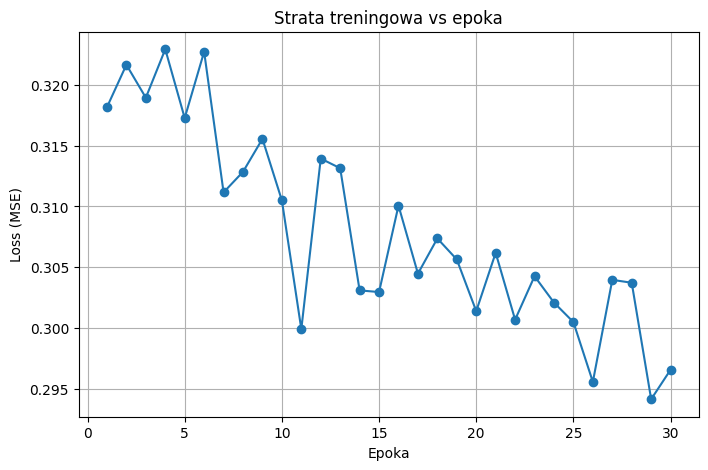

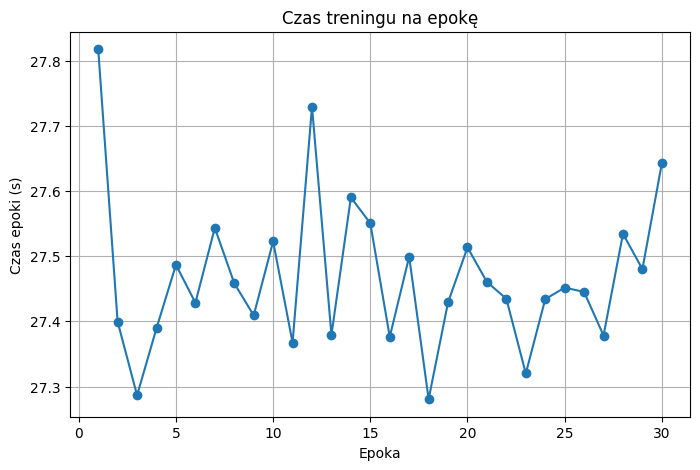

Finalny FID (na 10k próbkach): 68.99
Czas generowania 10k próbek: 1.17 min


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ścieżka do wyników
OUT_DIR = os.path.join("/content/drive/MyDrive/PGM_Project", "vae" if USE_VAE else "no_vae")
log_path = os.path.join(OUT_DIR, "training_log.csv")

# Wczytanie danych
df = pd.read_csv(log_path)

# === WYKRES LOSS vs EPOKA ===
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["loss"], marker="o")
plt.xlabel("Epoka")
plt.ylabel("Loss (MSE)")
plt.title("Strata treningowa vs epoka")
plt.grid(True)
plt.show()

# === WYKRES CZASU TRENINGU vs EPOKA ===
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["train_time"], marker="o")
plt.xlabel("Epoka")
plt.ylabel("Czas epoki (s)")
plt.title("Czas treningu na epokę")
plt.grid(True)
plt.show()

# === FID (po treningu) ===
fid = df["final_fid"].iloc[0] if "final_fid" in df.columns else None
if fid is not None:
    fid = float(fid)
    print(f"Finalny FID (na 10k próbkach): {fid:.2f}")
else:
    print("Brak danych o FID w logu.")

# === CZAS GENERACJI PRÓBEK ===
gen_time = df["gen_time"].iloc[0] if "gen_time" in df.columns else None
if gen_time is not None:
    gen_time = float(gen_time)
    print(f"Czas generowania 10k próbek: {gen_time/60:.2f} min")


In [ ]:
import os
import torch
import time
from PIL import Image
from tqdm.notebook import tqdm
from diffusers import DDIMPipeline

USE_VAE = True
RUN_NAME = "vae" if USE_VAE else "no_vae"
OUT_DIR = os.path.join("/content/drive/MyDrive/PGM_Project", RUN_NAME, "samples")
os.makedirs(OUT_DIR, exist_ok=True)

NUM_SAMPLES = 50
BATCH_SIZE = 16
SAMPLE_STEPS = 50
ETA = 0.0
SEED = 42

torch.manual_seed(SEED)

pipe = DDIMPipeline(unet=unet, scheduler=scheduler)
if USE_VAE and vae is not None:
    pipe.vae = vae
pipe = pipe.to(DEVICE)

unet_path = os.path.join("/content/drive/MyDrive/PGM_Project", RUN_NAME, "unet_best.pt")
vae_path = os.path.join("/content/drive/MyDrive/PGM_Project", RUN_NAME, "vae_best.pt")

if os.path.exists(unet_path):
    unet.load_state_dict(torch.load(unet_path, map_location=DEVICE))
if USE_VAE and vae is not None and os.path.exists(vae_path):
    vae.load_state_dict(torch.load(vae_path, map_location=DEVICE))

pipe.unet.eval()
if USE_VAE and vae is not None:
    pipe.vae.eval()

fake_images = []
start_time = time.perf_counter()

with torch.no_grad():
    for _ in tqdm(range(0, NUM_SAMPLES, BATCH_SIZE)):
        batch_size = min(BATCH_SIZE, NUM_SAMPLES - len(fake_images))
        result = pipe(batch_size=batch_size, num_inference_steps=SAMPLE_STEPS, eta=ETA)
        fake_images.extend(result.images)

for i, img in enumerate(fake_images):
    img.save(os.path.join(OUT_DIR, f"sample_{i+1:04d}.png"))

print(f"Zapisano {len(fake_images)} próbek do: {OUT_DIR}")
print(f"Czas generacji: {(time.perf_counter() - start_time) / 60:.2f} minut")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Zapisano 50 próbek do: /content/drive/MyDrive/PGM_Project/vae/samples
Czas generacji: 1.84 minut


## Porównanie wyników:

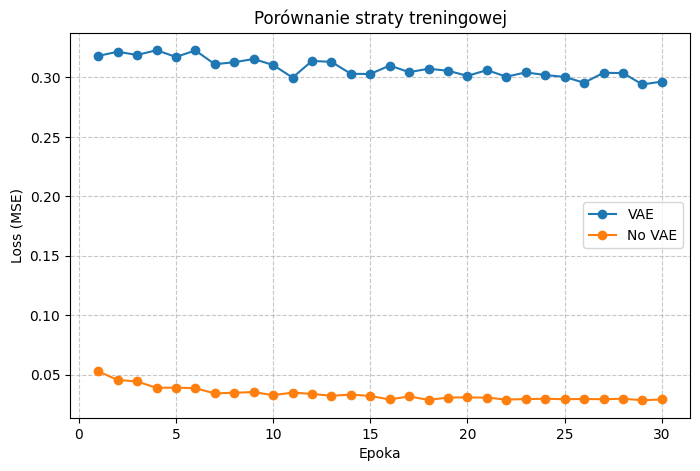

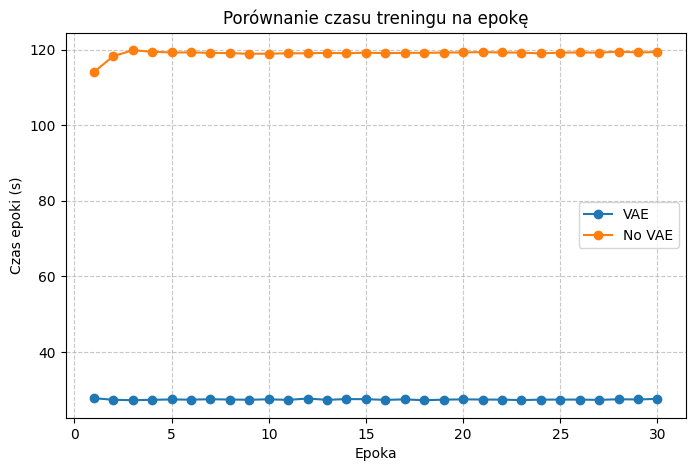

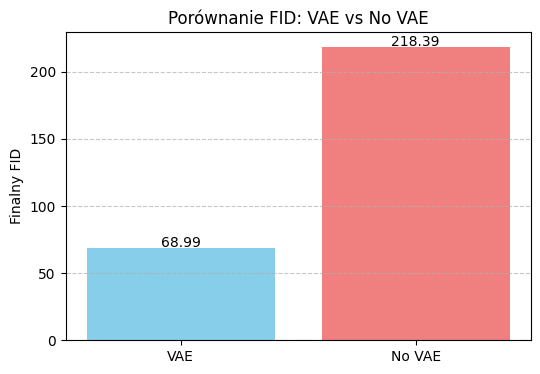

VAE final FID: 68.99
No VAE final FID: 218.39


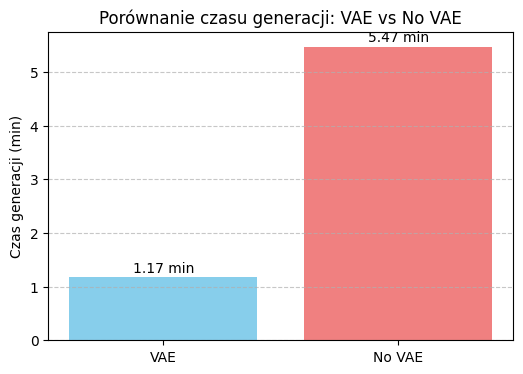

VAE generacja: 1.17 min
No VAE generacja: 5.47 min


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Wczytaj oba logi
df_vae = pd.read_csv("/content/drive/MyDrive/PGM_Project/vae/training_log.csv")
df_no_vae = pd.read_csv("/content/drive/MyDrive/PGM_Project/no_vae/training_log.csv")

# === WYKRES LOSS PORÓWNAWCZY ===
plt.figure(figsize=(8,5))
plt.plot(df_vae["epoch"], df_vae["loss"], label="VAE", marker="o")
plt.plot(df_no_vae["epoch"], df_no_vae["loss"], label="No VAE", marker="o")
plt.xlabel("Epoka")
plt.ylabel("Loss (MSE)")
plt.title("Porównanie straty treningowej")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# === WYKRES CZASU TRENINGU ===
plt.figure(figsize=(8,5))
plt.plot(df_vae["epoch"], df_vae["train_time"], label="VAE", marker="o")
plt.plot(df_no_vae["epoch"], df_no_vae["train_time"], label="No VAE", marker="o")
plt.xlabel("Epoka")
plt.ylabel("Czas epoki (s)")
plt.title("Porównanie czasu treningu na epokę")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# === FID i CZAS GENERACJI SŁUPKI ===
# Bezpieczne pobranie danych
vae_fid = df_vae["final_fid"].iloc[0] if "final_fid" in df_vae.columns else None
no_vae_fid = df_no_vae["final_fid"].iloc[0] if "final_fid" in df_no_vae.columns else None

vae_gen = df_vae["gen_time"].iloc[0]/60 if "gen_time" in df_vae.columns else None
no_vae_gen = df_no_vae["gen_time"].iloc[0]/60 if "gen_time" in df_no_vae.columns else None

# Wykres FID
if vae_fid is not None and no_vae_fid is not None:
    plt.figure(figsize=(6,4))
    plt.bar(["VAE", "No VAE"], [vae_fid, no_vae_fid], color=["skyblue", "lightcoral"])
    plt.ylabel("Finalny FID")
    plt.title("Porównanie FID: VAE vs No VAE")
    for i, v in enumerate([vae_fid, no_vae_fid]):
        plt.text(i, v + 0.5, f"{v:.2f}", ha="center")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
    print(f"VAE final FID: {vae_fid:.2f}")
    print(f"No VAE final FID: {no_vae_fid:.2f}")
else:
    print("Brak danych FID do porównania.")

# Wykres czasu generacji
if vae_gen is not None and no_vae_gen is not None:
    plt.figure(figsize=(6,4))
    plt.bar(["VAE", "No VAE"], [vae_gen, no_vae_gen], color=["skyblue", "lightcoral"])
    plt.ylabel("Czas generacji (min)")
    plt.title("Porównanie czasu generacji: VAE vs No VAE")
    for i, v in enumerate([vae_gen, no_vae_gen]):
        plt.text(i, v + 0.1, f"{v:.2f} min", ha="center")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
    print(f"VAE generacja: {vae_gen:.2f} min")
    print(f"No VAE generacja: {no_vae_gen:.2f} min")
else:
    print("Brak danych o czasie generacji do porównania.")

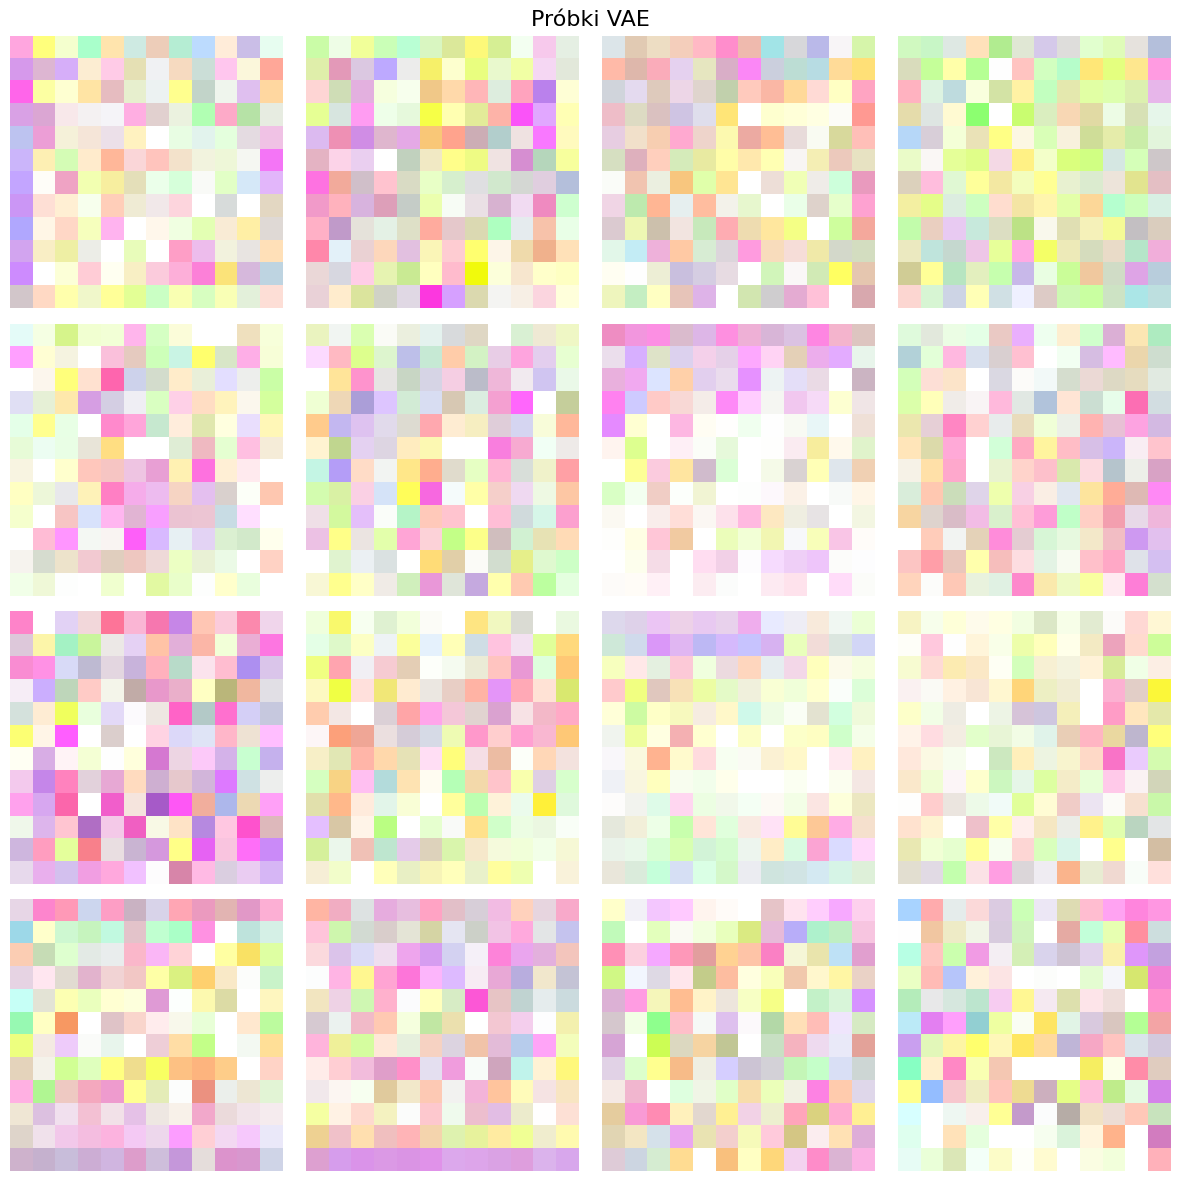

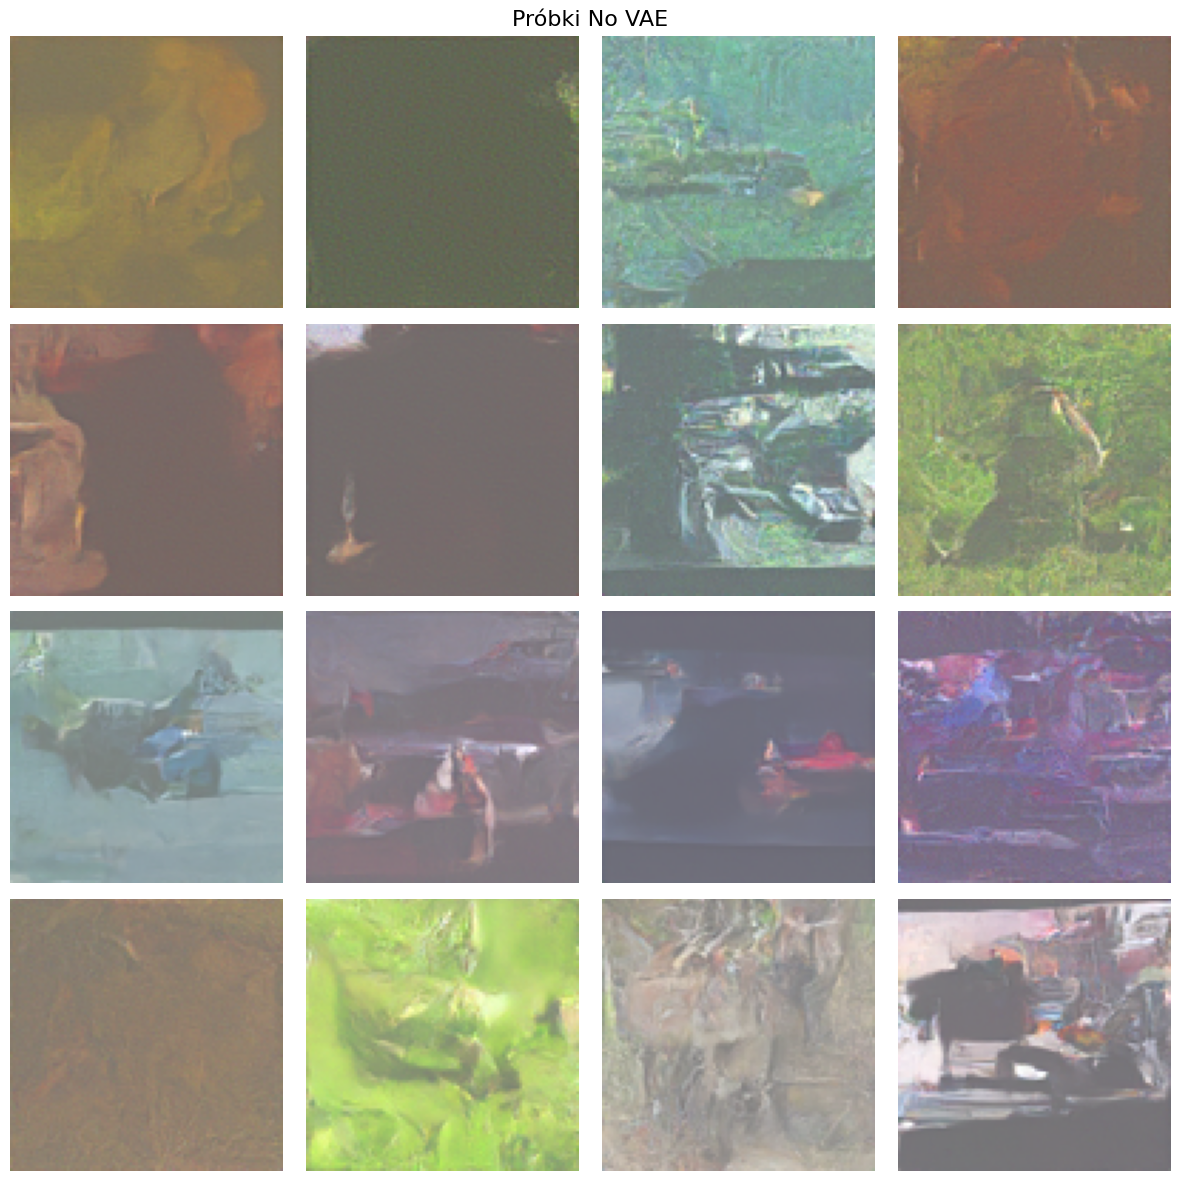

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import glob

def show_samples_grid(folder_path, title, max_samples=16):
    # Wczytaj ścieżki do obrazów
    img_paths = sorted(glob.glob(os.path.join(folder_path, "*.png")))
    img_paths = img_paths[:max_samples]

    if not img_paths:
        print(f"Brak próbek w {folder_path}")
        return

    # Wczytaj obrazy
    imgs = [Image.open(p) for p in img_paths]

    # Wyznacz układ siatki
    cols = min(4, len(imgs))
    rows = (len(imgs) + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axes = axes.flatten()

    for ax, img in zip(axes, imgs):
        ax.imshow(img)
        ax.axis("off")

    # Wyłącz puste osie jeśli obrazów jest mniej niż slotów
    for ax in axes[len(imgs):]:
        ax.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# === ŚCIEŻKI DO PRÓBEK ===
vae_samples_dir = "/content/drive/MyDrive/PGM_Project/vae/samples"
no_vae_samples_dir = "/content/drive/MyDrive/PGM_Project/no_vae/samples"

# === WIZUALIZACJA ===
show_samples_grid(vae_samples_dir, "Próbki VAE")
show_samples_grid(no_vae_samples_dir, "Próbki No VAE")